# Clasificador de flores

Bienvenidos. En este ejercicio haremos un clasificador para flores. Usaremos el siguiente dataset: http://www.robots.ox.ac.uk/~vgg/data/flowers/, que contiene 102 categorías y 8192 imágenes de flores de alta calidad. En un momento te diré cómo descargar el dataset ya editado por mi para hacerlo más fácil de manejar.

### Inicio
Primero que nada, toda libreta deberá contener las siguientes 3 lineas. No te preocupes qué hacen por ahora, sólo ponlas y ya (son utilidades).

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

Vamos a incluir las bibliotecas que usaremos, que son [fast.ai](https://www.fast.ai/) y [pytorch](https://pytorch.org).

In [2]:
import fastai as fai
import fastai.vision as fv

### ¿Cómo son nuestros datos?

Siempre antes de empezar a trabajar en algún problema, hay que entender bien qué problema queremos resolver. En este caso, simplemente queremos clasificar flores en base a sus imágenes.

Después, hay que entender los datos que nos dan, en qué formato están, etc. Bajaremos los datos de así (descomenta la siguientes líneas para bajar los datos) (nota que el ! en jupyter significa "corre el siguiente comando de bash")

In [3]:
#!wget http://blabla.com/flowers.tar.gz
#!tar xzf flowers.tar.gz

Esto creará una carpeta llamada "flowers" que contendrá dos subcarpetas: train y valid.

In [4]:
!ls flowers

models	train  valid


In [5]:
!ls flowers/train

alpine-sea-holly    fire-lily		       peruvian-lily
anthurium	    foxglove		       petunia
artichoke	    frangipani		       pincushion-flower
azalea		    fritillary		       pink-primrose
ball-moss	    garden-phlox	       pink-yellow-dahlia
balloon-flower	    gaura		       poinsettia
barbeton-daisy	    gazania		       primula
bearded-iris	    geranium		       prince-of-wales-feathers
bee-balm	    giant-white-arum-lily      purple-coneflower
bird-of-paradise    globe-flower	       red-ginger
bishop-of-llandaff  globe-thistle	       rose
blackberry-lily     grape-hyacinth	       ruby-lipped-cattleya
black-eyed-susan    great-masterwort	       siam-tulip
blanket-flower	    hard-leaved-pocket-orchid  silverbush
bolero-deep-blue    hibiscus		       snapdragon
bougainvillea	    hippeastrum		       spear-thistle
bromelia	    japanese-anemone	       spring-crocus
buttercup	    king-protea		       stemless-gentian
californian-poppy   lenten-rose		       sunflower
camellia	    lotus		       sweet

In [6]:
!ls flowers/valid/artichoke

image_04090.jpg  image_04097.jpg  image_04140.jpg
image_04095.jpg  image_04130.jpg


Ya entendimos cómo están las imágenes y su clasificación. (Nota: el archivo original no estaba bien acomodado así!)

## Abriendo los datos en fastai

Dado que nuestros datos están bien acomodados, vamos a crear un "databunch". Primero aplicaremos "data augmentation" (más sobre esto después)

In [7]:
tfms = fv.get_transforms(flip_vert=True, max_rotate=360, max_zoom=1.2, max_lighting=0.4)

Ahora cargaremos los datos

In [8]:
def load_data(folder, img_size, batch_size):
    data = (fv.ImageItemList
            .from_folder(folder)
            .split_by_folder()
            .label_from_folder()
            .transform(tfms,size=img_size)
            .databunch(bs=batch_size)
            .normalize(fv.imagenet_stats))
    return data

In [9]:
data = load_data("flowers", img_size=224, batch_size=32)

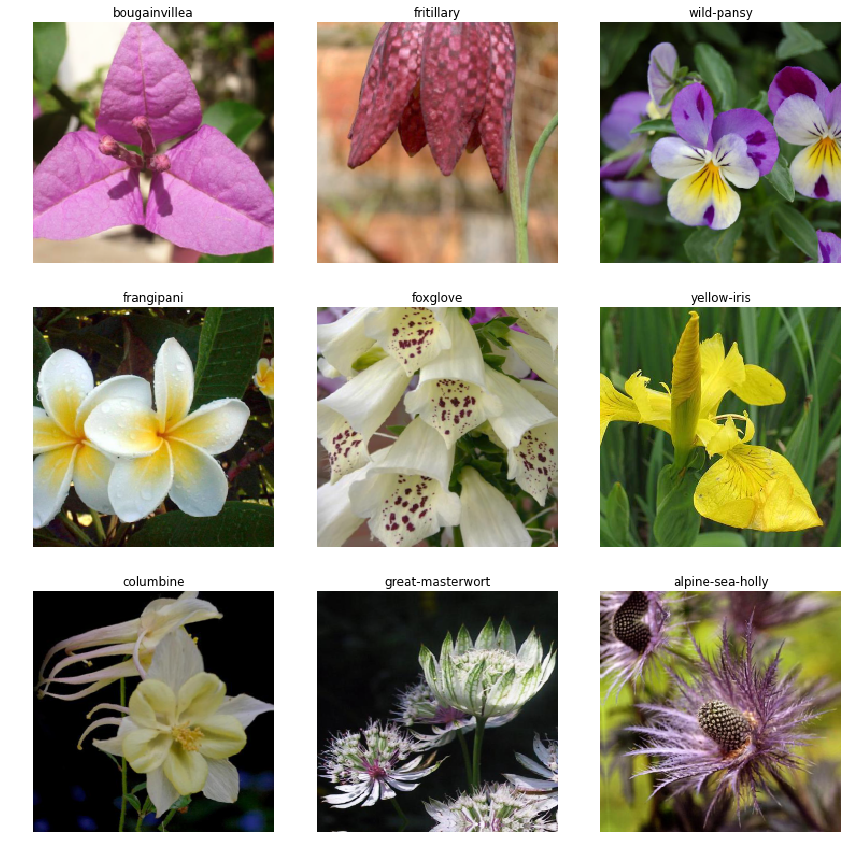

In [10]:
data.show_batch(rows=3)

## Entrenamiento

Ahora crearemos un objeto de tipo "Learner" (más sobre esto después), con arquitectura de "resnet18". Qué es esto? No te preocupes!

In [11]:
learner = fv.create_cnn(data, fv.models.resnet101, metrics=fai.accuracy)

### Entrenamiento sólo de las últimas capas

Podríamos usar la función "fit", pero la función "fit_one_cycle" es más rápida (discutiremos por qué)

In [12]:
learner.fit_one_cycle(1,wd=0.1)

epoch,train_loss,valid_loss,accuracy
1,0.686052,0.298570,0.946640


In [13]:
learner.fit_one_cycle(6,wd=0.1)

epoch,train_loss,valid_loss,accuracy
1,0.404320,0.222847,0.934783
2,0.301451,0.146128,0.966403
3,0.139626,0.094390,0.974308
4,0.078161,0.094185,0.976285


Ahora, parece que nos estamos quedando atorados. Qué learning rate usamos? Pues vamos a averiguar!

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


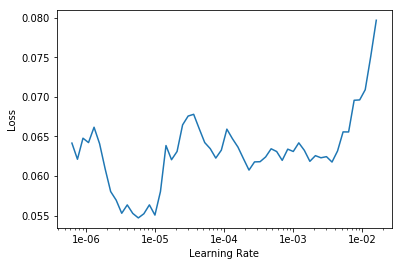

In [14]:
learner.lr_find(); learner.recorder.plot()

In [15]:
learner.fit_one_cycle(6,max_lr=1e-5,wd=0.1)

epoch,train_loss,valid_loss,accuracy
1,0.071192,0.089031,0.980237
2,0.074760,0.089960,0.982213
3,0.074754,0.085345,0.980237
4,0.069282,0.088512,0.980237
5,0.067877,0.089006,0.976285
6,0.067758,0.089028,0.982213


En realidad **no hemos estado entrenando a toda la red neuronal!!** Sólo entrenamos las últimas dos capas, y las demás estaban **pre-entrenadas en imagenet**. Por defecto, si pides una arquitectura pre-hecha, vienen "congeladas" las primeras capas. Vamos a entrenar con cuidado a toda la red.


In [17]:
learner.save('stage1res101')

### Entrenamiento de TODAS las capas

In [16]:
learner.unfreeze() # ahora hay que tener cuidado!

Vamos a entrenar toda la red, pero vamos a modificar las primeras capas **menos que las últimas**

In [18]:
learner.fit_one_cycle(4, max_lr=slice(4e-7, 4e-4), wd=0.15)

epoch,train_loss,valid_loss,accuracy
1,0.072417,0.089473,0.978261
2,0.067597,0.068827,0.984190
3,0.034363,0.064518,0.988142
4,0.026867,0.062867,0.988142


In [19]:
learner.fit_one_cycle(6, max_lr=slice(2e-7, 1e-4), wd=0.15)

epoch,train_loss,valid_loss,accuracy
1,0.024200,0.063724,0.984190
2,0.021103,0.067342,0.986166
3,0.018537,0.062858,0.986166
4,0.016239,0.059159,0.986166
5,0.020071,0.057030,0.988142
6,0.015614,0.059167,0.988142


In [21]:
learner.save('stage2')

NameError: name 'learn' is not defined

### One cycle

Como funciona el método fit_one_cycle? Se ha encontrado que ir modificando la taza de aprendizaje (learning rate) en "ciclos" mejora mucho el resultado final de la red. Después entenderemos la razón, pero tiene que ver con que son mejores los "mínimos gordos" que los "mínimos flacos".

In [ ]:
learner.recorder.plot_lr(show_moms=True)

# Interpretando los resultados

In [20]:
fai.accuracy(*learner.TTA())

tensor(0.9921)

In [ ]:
interp = learner.interpret()

In [ ]:
interp.plot_top_losses(9)

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)